In [8]:
import sys
sys.path.insert(0, '/home/noamatia/repos/control_point_e/')

In [9]:
import os
import torch
import shutil
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from point_e.util.plotting import plot_point_cloud
from point_e.models.download import load_checkpoint
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
os.environ['EXPERIMENT1_TMP_DIR'] = "experiment1_tmp"

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])
base_model.load_state_dict(load_checkpoint(base_name, device))

<All keys matched successfully>

In [11]:
sampler = PointCloudSampler(
    device=device,
    s_churn = [3],
    sigma_max = [120],
    num_points=[1024],
    sigma_min = [1e-3],
    models=[base_model],
    use_karras = [True],
    karras_steps = [64],
    guidance_scale=[3.0],
    diffusions=[base_diffusion],
    aux_channels=['R', 'G', 'B'],
    model_kwargs_key_filter=['texts']
)

In [12]:
def plot_pc(sampler, samples, j, output_dir, experimental1_t, prompt):
    pc = sampler.output_to_point_clouds(samples)[j]
    fig = plot_point_cloud(pc, color=False)
    fig.savefig(os.path.join(output_dir, f'{experimental1_t}_{prompt}.png'))
    plt.close()

In [19]:
experimental1_t = 30
sampler.experiment1_t = experimental1_t
prompt1, prompt2 = 'an_office_chair', 'an_office_chair_with_wheels'

65it [00:13,  4.96it/s]00:00<?, ?it/s]
65it [00:16,  3.98it/s]00:13<01:59, 13.25s/it]
65it [00:13,  4.79it/s]00:29<02:01, 15.16s/it]
65it [00:13,  4.76it/s]00:43<01:41, 14.50s/it]
65it [00:13,  4.69it/s]00:57<01:25, 14.22s/it]
65it [00:13,  4.95it/s]01:11<01:10, 14.15s/it]
65it [00:14,  4.62it/s]01:24<00:55, 13.85s/it]
39it [00:05,  7.31it/s]01:38<00:41, 13.97s/it]
 70%|███████   | 7/10 [01:44<00:44, 14.87s/it]


KeyboardInterrupt: 

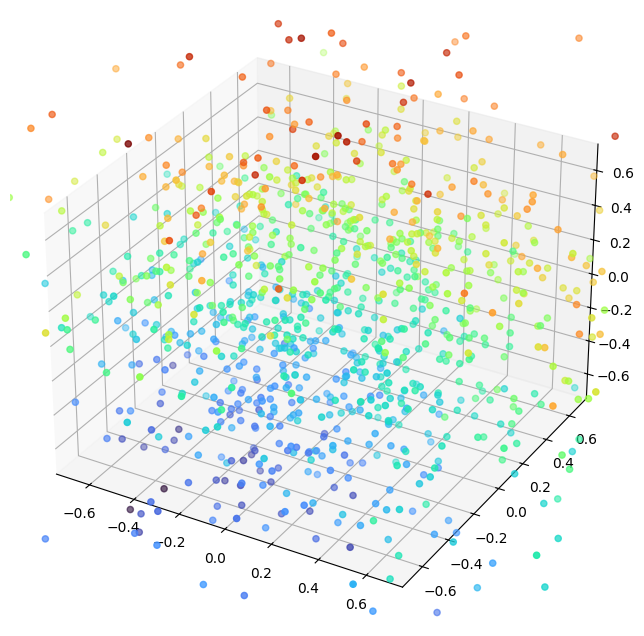

In [18]:
os.makedirs(os.environ['EXPERIMENT1_TMP_DIR'], exist_ok=True)
html = "<table>\n"
for i in tqdm(range(25), total=25):
    output_dir = os.path.join('experiment1_html', f'{prompt1}_{prompt2}_{i}')
    os.makedirs(output_dir, exist_ok=True)
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=2, model_kwargs=dict(texts=[prompt1.replace("_", " "), prompt2.replace("_", " ")]))):
        samples = x
    for j, prompt in zip(range(2), [prompt1, prompt2]):
        plot_pc(sampler, samples, j, output_dir, experimental1_t, prompt)
    for file in os.listdir(os.getenv('EXPERIMENT1_TMP_DIR')):
        shutil.move(os.path.join(os.getenv('EXPERIMENT1_TMP_DIR'), file), 
                    os.path.join(output_dir, file))
    col1 = col2 = f'{prompt1} (t={experimental1_t})'
    col3 = col4 = f'{prompt2} (t={experimental1_t})'
    html += f'<tr><td><font size="5">{col1}</font></td><td><font size="5">{col2}</font></td><td><font size="5">{col3}</font></td><td><font size="5">{col4}</font></td></tr>\n'
    col1_src = f'{output_dir}/{experimental1_t}_{prompt1}.png'
    col3_src = f'{output_dir}/{experimental1_t}_{prompt2}.png'
    col2_src = f'{output_dir}/{experimental1_t}_0.gif'
    col4_src = f'{output_dir}/{experimental1_t}_1.gif'
    html += f"<tr><td><img src='{col1_src}'></td><td><img src='{col2_src}'></td><td><img src='{col3_src}'></td><td><img src='{col4_src}'></td></tr>\n"
html += "</table>"
with open('experiment1.html', 'w') as f:
    f.write(html)
os.rmdir(os.getenv('EXPERIMENT1_TMP_DIR'))